### Aum Amriteshwariyae Namaha
### Brain Tumor Detection using ResNet

#### Importing Libraries

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch

#### Analysis of Data

In [3]:
# Assuming your dataset is structured with one folder per class
dataset_path = '/Users/amritanand/Documents/Programming/Brain tumors/Data'  # Update this to your dataset path

dataset = ImageFolder(root=dataset_path)
class_counts = {class_name: 0 for class_name in dataset.classes}

for _, label in dataset:
    class_name = dataset.classes[label]
    class_counts[class_name] += 1

print(class_counts)

{'glioma_tumor': 901, 'meningioma_tumor': 913, 'normal': 438, 'pituitary_tumor': 844}


#### Balancing the data

In [4]:
# Transformations and dataset loading as you've defined
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
full_dataset = ImageFolder(root=dataset_path, transform=transform)

# Determine the number of images per class for balancing
min_images = 438  # Number of images in the smallest class

# Create indices for a balanced dataset
indices = []
for class_index in range(len(full_dataset.classes)):
    class_indices = [i for i, (_, label) in enumerate(full_dataset.samples) if label == class_index]
    np.random.shuffle(class_indices)
    indices += class_indices[:min_images]

# Shuffle the indices to mix classes
np.random.shuffle(indices)

# Create a balanced dataset
balanced_dataset = Subset(full_dataset, indices)


#### Splitting of Dataset

In [5]:
# Assuming the balanced_dataset is already created and consists of an equal number of images per class

# Split the balanced dataset into training and testing datasets
train_size = int(0.8 * len(balanced_dataset))
test_size = len(balanced_dataset) - train_size
train_dataset, test_dataset = random_split(balanced_dataset, [train_size, test_size])

# Function to calculate class distribution in a dataset
def get_class_distribution(dataset, idx_to_class):
    # Initialize count dictionary
    count_dict = {class_name: 0 for class_name in idx_to_class.values()}
    
    # Loop over the dataset to count each class
    for idx in dataset.indices:  # dataset.indices for Subset
        _, label = balanced_dataset[idx]
        class_name = idx_to_class[label]
        count_dict[class_name] += 1
        
    return count_dict

# idx_to_class mapping from numerical labels to class names
idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}

# Calculate class distribution
train_class_distribution = get_class_distribution(train_dataset, idx_to_class)
test_class_distribution = get_class_distribution(test_dataset, idx_to_class)

# Print class distribution
print("Training set class distribution:", train_class_distribution)
print("Test set class distribution:", test_class_distribution)


Training set class distribution: {'glioma_tumor': 347, 'meningioma_tumor': 357, 'normal': 348, 'pituitary_tumor': 349}
Test set class distribution: {'glioma_tumor': 91, 'meningioma_tumor': 81, 'normal': 90, 'pituitary_tumor': 89}


#### Updating Data Loader Usage

In [6]:
# Create data loaders for the balanced datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

#### Visualizing distributions of train and test

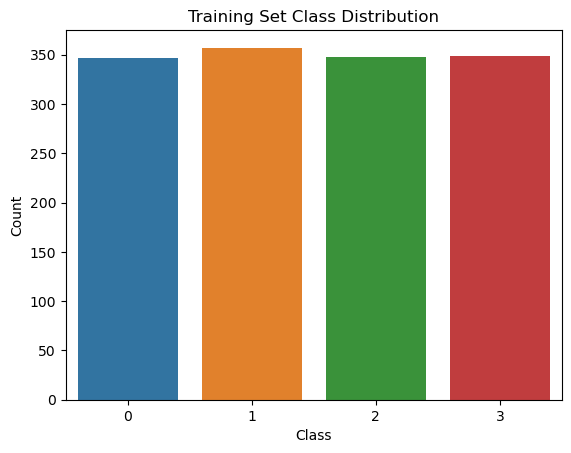

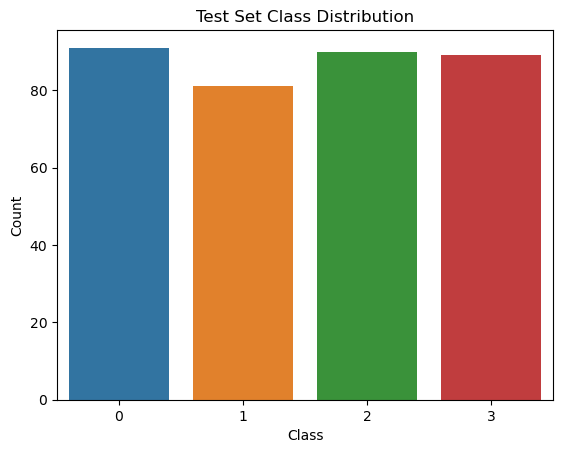

In [7]:
# Visualization of class distribution in the balanced training and test datasets
def visualize_class_distribution(loader, title):
    labels = [label for _, label in loader.dataset]
    label_counts = pd.Series(labels).value_counts().sort_index()
    sns.barplot(x=label_counts.index, y=label_counts.values)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

# Visualize class distribution
visualize_class_distribution(train_loader, 'Training Set Class Distribution')
visualize_class_distribution(test_loader, 'Test Set Class Distribution')

#### Visualizing Sample images

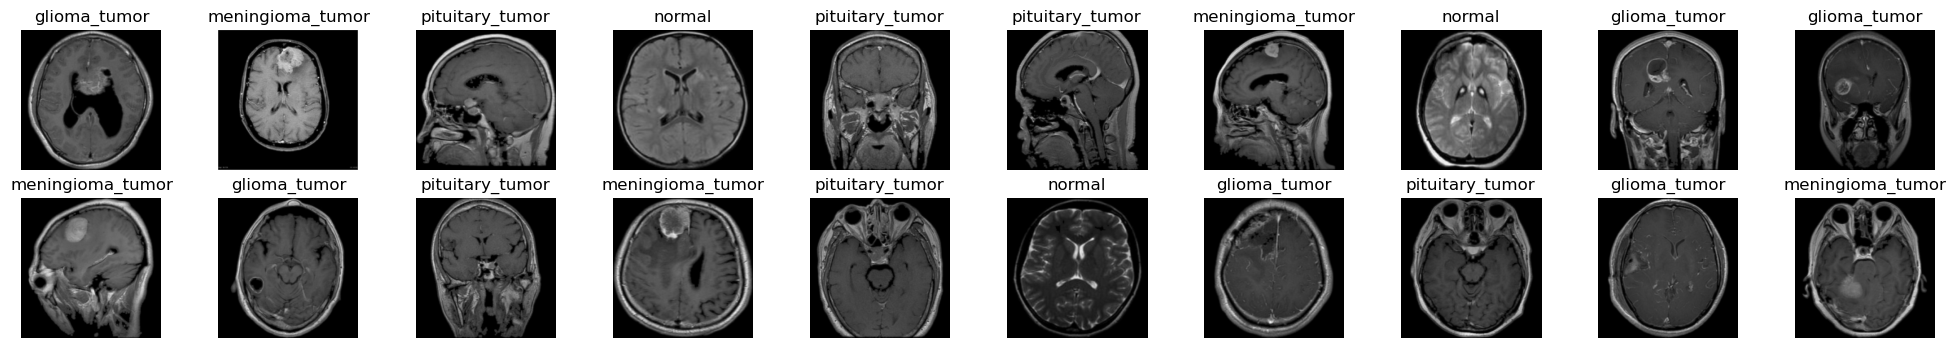

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    """Function to show an image"""
    img = img.numpy().transpose((1, 2, 0))  # convert from Tensor image
    plt.imshow(img)
    plt.axis('off')  # don't show axes for images

# Assuming train_loader is your DataLoader for the training set
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Assuming idx_to_class mapping from label indices to class names
idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}  # Adjust as necessary

fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(idx_to_class[labels[idx].item()])


#### Defining the ResNet Model

In [9]:
# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
def create_resnet_model(num_classes=4):
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model.to(device)

model = create_resnet_model()


/Users/amritanand/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/amritanand/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Training the Model

In [10]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

#Training loop
num_epochs = 15  # Adjust as needed

for epoch in range(num_epochs):
    # Timing the epoch for training
    start_time = time.time()

    # Training Phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100 * correct / total
    train_time = time.time() - start_time

    # Validation Phase
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()  # Timing the epoch for validation
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(test_loader.dataset)
    val_acc = 100 * correct / total
    val_time = time.time() - start_time

    # Print the metrics
    print(f"[Train #{epoch+1}] Loss: {train_loss:.4f} Acc: {train_acc:.4f}% Time: {train_time:.4f}s")
    print(f"[Validation #{epoch+1}] Loss: {val_loss:.4f} Acc: {val_acc:.4f}% Time: {val_time:.4f}s")



[Train #1] Loss: 0.4925 Acc: 82.2270% Time: 25.9851s
[Validation #1] Loss: 0.3020 Acc: 87.7493% Time: 1.9975s
[Train #2] Loss: 0.0994 Acc: 97.1449% Time: 22.3938s
[Validation #2] Loss: 0.1921 Acc: 92.5926% Time: 1.8672s
[Train #3] Loss: 0.0477 Acc: 99.0007% Time: 22.3474s
[Validation #3] Loss: 0.2876 Acc: 92.3077% Time: 1.8688s
[Train #4] Loss: 0.0419 Acc: 98.8580% Time: 22.3263s
[Validation #4] Loss: 0.2656 Acc: 92.3077% Time: 1.8698s
[Train #5] Loss: 0.0337 Acc: 99.1435% Time: 22.3228s
[Validation #5] Loss: 0.1962 Acc: 93.7322% Time: 1.8768s
[Train #6] Loss: 0.0237 Acc: 99.4290% Time: 22.3463s
[Validation #6] Loss: 0.2702 Acc: 93.1624% Time: 1.8819s
[Train #7] Loss: 0.0212 Acc: 99.0721% Time: 29.9086s
[Validation #7] Loss: 0.2299 Acc: 93.7322% Time: 1.9546s
[Train #8] Loss: 0.0248 Acc: 99.2148% Time: 22.8236s
[Validation #8] Loss: 0.3064 Acc: 93.4473% Time: 1.9512s
[Train #9] Loss: 0.0389 Acc: 98.9293% Time: 22.7137s
[Validation #9] Loss: 0.2142 Acc: 93.7322% Time: 1.9024s
[Train #10

#### Evaluation of the model

In [11]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on the test dataset: {100 * correct / total}%')

Accuracy on the test dataset: 86.32478632478633%


In [16]:
from sklearn.metrics import classification_report
import torch

# Assuming your model and test_loader are defined
model.eval()  # Set the model to evaluation mode

all_preds = []
all_targets = []

# No gradients needed for evaluation, which saves memory and computations
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)  # Ensure this matches your device configuration
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

print(classification_report(all_targets, all_preds, target_names=['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']))


                  precision    recall  f1-score   support

    glioma_tumor       0.92      0.84      0.87        91
meningioma_tumor       0.90      0.65      0.76        81
          normal       0.80      1.00      0.89        90
 pituitary_tumor       0.88      0.94      0.91        89

        accuracy                           0.86       351
       macro avg       0.87      0.86      0.86       351
    weighted avg       0.87      0.86      0.86       351



#### Predction using Unseen Images

In [17]:
from PIL import Image
import torchvision.transforms as transforms

# Function to load an image and predict its class
def predict_image(image_path, model, device):
    # Image transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    
    # Load the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Move the image to the appropriate device
    image = image.to(device)
    
    # Set the model to evaluation mode and make predictions
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    
    # Convert the prediction index to class name
    idx_to_class = {v: k for k, v in full_dataset.class_to_idx.items()}
    prediction = idx_to_class[predicted.item()]
    
    return prediction

# Example usage
image_path = '/Users/amritanand/Documents/Programming/Brain tumors/Data/normal/N_10.jpg'  # Update this path
prediction = predict_image(image_path, model, device)
print(f"Predicted class: {prediction}")


Predicted class: normal
